# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/VISION COMPUTACIONAL'
os.chdir(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [ ]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [ ]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [ ]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

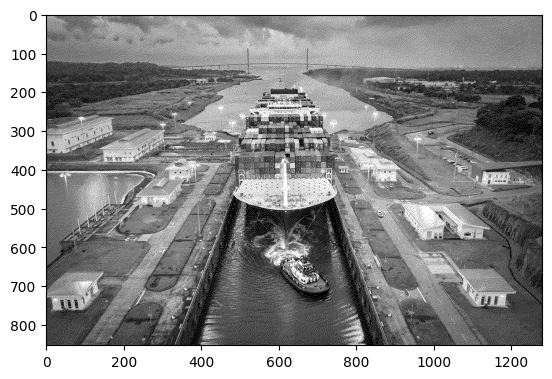

In [ ]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

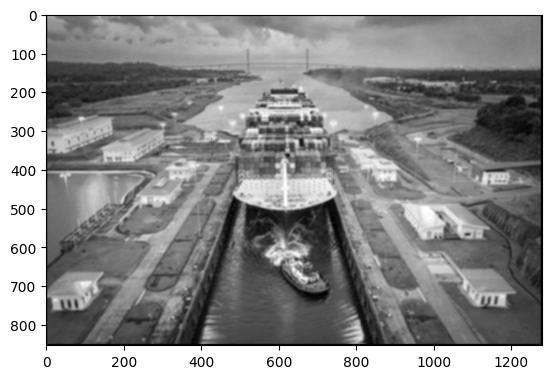

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [ ]:
#!pip uninstall Pillow
#!pip install Pillow==9.5.0

In [ ]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-137-7c8c44ebc1df>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


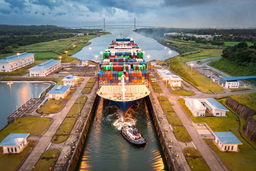

In [ ]:
img

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 171, 256])

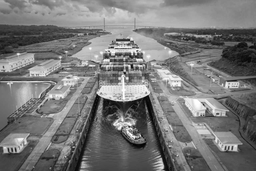

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0931, -0.0435, -0.0569,  ..., -0.0320, -0.0339, -0.0470],
         [-0.2355,  0.0011,  0.0066,  ...,  0.0029, -0.0010,  0.0645],
         [-0.2381,  0.0068,  0.0056,  ...,  0.0075,  0.0043,  0.0648],
         ...,
         [-0.1029,  0.0031,  0.0026,  ...,  0.0037,  0.0082,  0.0397],
         [-0.1003, -0.0004, -0.0003,  ...,  0.0028,  0.0043,  0.0353],
         [-0.0222,  0.0279,  0.0275,  ...,  0.0288,  0.0268, -0.0030]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 171, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 171, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 171, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 171, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

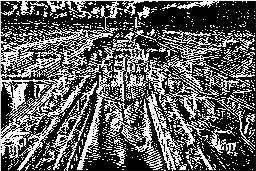

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

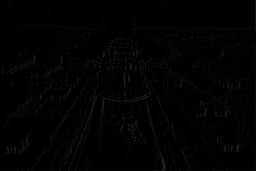

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [ ]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

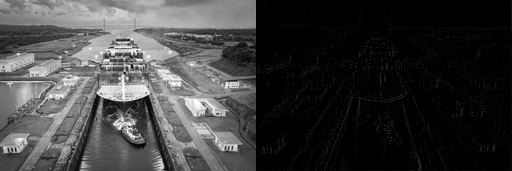

In [ ]:
display(input, output)

### Identity

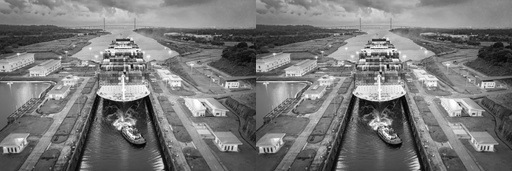

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


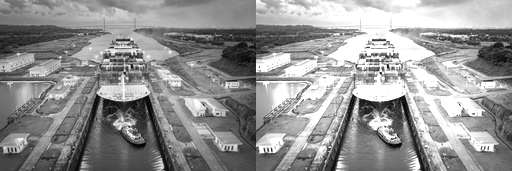

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


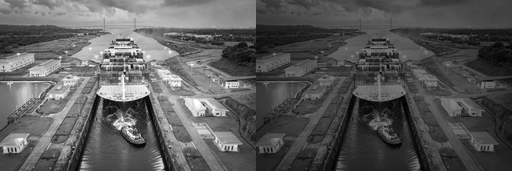

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


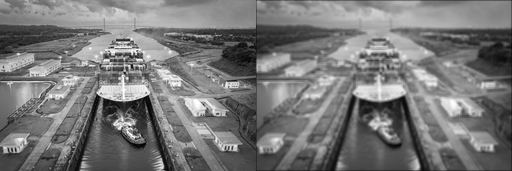

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


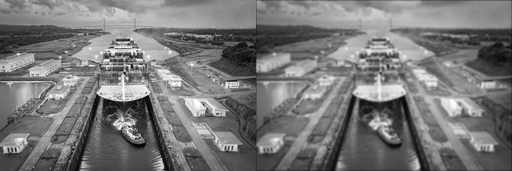

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


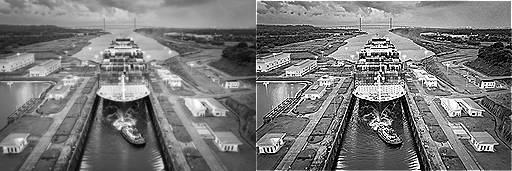

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


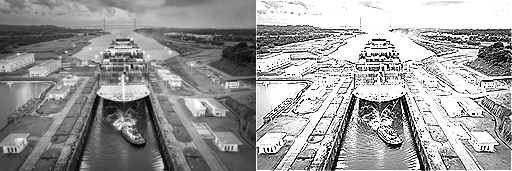

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


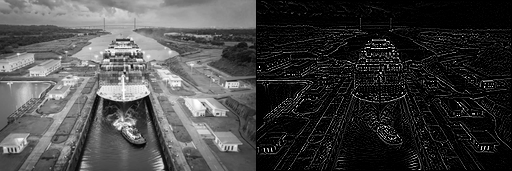

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

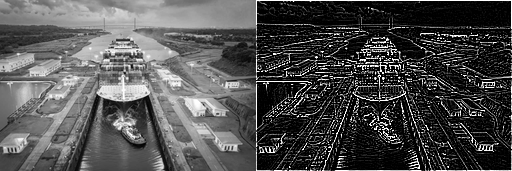

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

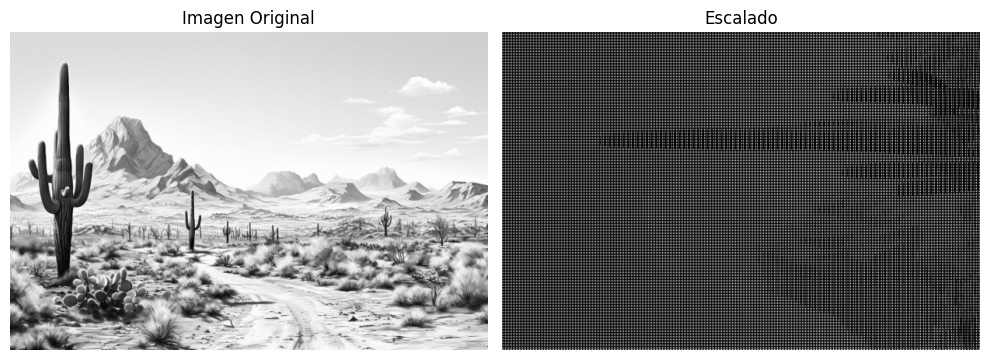

In [ ]:
# TODO: Challenge, hard image with hard transformations

# Cargar una imagen de ejemplo (puedes reemplazarla con tu propia imagen)
image_path = 'data/cactus.jpg'  # Reemplaza con el path de tu imagen
image = Image.open(image_path).convert('L')  # Convertir a escala de grises para simplicidad
image = np.array(image)  # Convertir a numpy array

# Convertir la imagen a tensor
image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()  # Forma (1, 1, H, W)

# Convertir la imagen a tensor
image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()  # Forma (1, 1, H, W)

# 1. Escalado (sin rotación)
def scale_image(image_tensor, scale_factor):
    H, W = image_tensor.shape[2], image_tensor.shape[3]

    # Matriz de escala
    scaling_matrix = torch.tensor([
        [scale_factor, 0, 0],
        [0, scale_factor, 0],
        [0, 0, 1]
    ], dtype=torch.float32)  # Aseguramos que la matriz sea de tipo float32

    # Crear la malla de coordenadas
    grid_x, grid_y = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='ij')
    ones = torch.ones_like(grid_x)

    # Convertimos coords a float32
    coords = torch.stack([grid_x.flatten(), grid_y.flatten(), ones.flatten()], dim=0).float()  # Convertimos a float32

    # Transponer coords para la multiplicación de matrices
    coords = coords.T  # Cambiamos a forma (N, 3), donde N es el número total de píxeles

    # Aplicar transformación
    new_coords = coords @ scaling_matrix.T  # Multiplicamos coords por la transpuesta de scaling_matrix
    new_coords = new_coords.T  # Volver a la forma (3, N)

    new_coords[0, :] = torch.clamp(new_coords[0, :], 0, W-1)  # Recortar a los límites
    new_coords[1, :] = torch.clamp(new_coords[1, :], 0, H-1)

    new_x = new_coords[0, :].reshape(H, W)
    new_y = new_coords[1, :].reshape(H, W)

    # Crear nueva imagen
    new_image = torch.zeros_like(image_tensor)
    for i in range(H):
        for j in range(W):
            x = int(new_x[i, j].item())
            y = int(new_y[i, j].item())
            new_image[0, 0, y, x] = image_tensor[0, 0, i, j]

    return new_image

# Aplicar solo escalado (sin rotación)
scaled_image = scale_image(image_tensor, 2)

# Mostrar los resultados
def display_images(input_img, transformed_img):
    input_np = input_img.squeeze().detach().numpy()
    transformed_np = transformed_img.squeeze().detach().numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(input_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Escalado")
    plt.imshow(transformed_np, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar imágenes transformadas
display_images(image_tensor, scaled_image)

# EJERCICIOS

#### **1. Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?**

In [ ]:
# Función para cargar y convertir una imagen a escala de grises
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    return np.array(image)

# Operador de Prewitt en X y Y
def prewitt(image):
    # Filtros Prewitt
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

    # Aplicar convolución (sin usar OpenCV)
    grad_x = convolution(image, kernel_x)
    grad_y = convolution(image, kernel_y)

    # Magnitud del gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return magnitude

# Operador de Sobel en X y Y
def sobel(image):
    # Filtros Sobel
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Aplicar convolución (sin usar OpenCV)
    grad_x = convolution(image, kernel_x)
    grad_y = convolution(image, kernel_y)

    # Magnitud del gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return magnitude

# Operador Laplaciano
def laplacian(image):
    # Filtro Laplaciano (usamos un kernel de 3x3)
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Aplicar convolución (sin usar OpenCV)
    result = convolution(image, kernel)
    return result

# Convolución con un kernel específico
def convolution(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Padding para manejar los bordes
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded_image[i:i+kernel_h, j:j+kernel_w]
            result[i, j] = np.sum(region * kernel)

    return result

# Función para mostrar las imágenes
def display_images(original, prewitt_img, sobel_img, laplacian_img):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Imagen Original")


    plt.subplot(2, 2, 2)
    plt.imshow(prewitt_img, cmap='gray')
    plt.title("Prewitt")


    plt.subplot(2, 2, 3)
    plt.imshow(sobel_img, cmap='gray')
    plt.title("Sobel")


    plt.subplot(2, 2, 4)
    plt.imshow(laplacian_img, cmap='gray')
    plt.title("Laplaciano")


    plt.tight_layout()
    plt.show()

# Cargar la imagen y aplicar los filtros
image_path = 'data/cactus.jpg'  # Reemplaza con tu imagen
image = load_image(image_path)

# Aplicar los detectores de bordes
prewitt_img = prewitt(image)
sobel_img = sobel(image)
laplacian_img = laplacian(image)

# Mostrar los resultados
display_images(image, prewitt_img, sobel_img, laplacian_img)

Output hidden; open in https://colab.research.google.com to view.

#### **2. Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.**

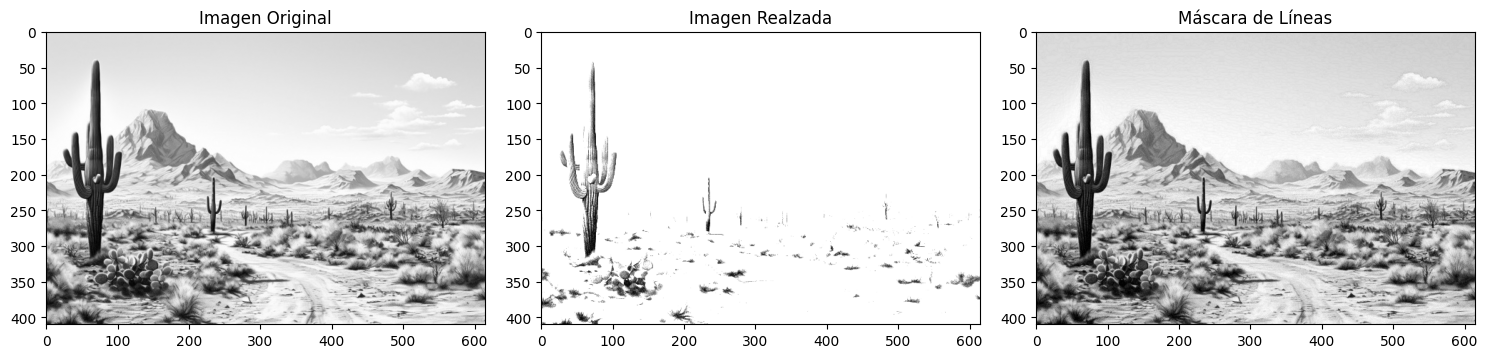

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Función para cargar y convertir una imagen a escala de grises
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    return np.array(image)

# Operador Sobel en X y Y
def sobel(image):
    # Filtros Sobel
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Aplicar convolución (sin usar OpenCV)
    grad_x = convolution(image, kernel_x)
    grad_y = convolution(image, kernel_y)

    # Magnitud del gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return magnitude

# Convolución con un kernel específico
def convolution(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Padding para manejar los bordes
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded_image[i:i+kernel_h, j:j+kernel_w]
            result[i, j] = np.sum(region * kernel)

    return result

# Función para realzar la imagen con líneas
def enhance_image(image, alpha=2):
    # 1. Detectar líneas usando Sobel
    lines = sobel(image)

    # 2. Crear la máscara de líneas (diferencia entre la imagen original y la imagen con líneas)
    mask = np.abs(image - lines)

    # 3. Realzar la imagen multiplicando la máscara de líneas por un factor alfa
    enhanced_mask = mask * alpha # 4. Sumar la máscara realzada a la imagen original (realce de líneas)
    enhanced_image = np.clip(image + enhanced_mask, 0, 255)  # Asegurar que los valores estén en el rango [0, 255]

    return enhanced_image, mask

# Función para mostrar las imágenes
def display_images(original, enhanced, mask):
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Imagen Original")

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Imagen Realzada")

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Máscara de Líneas")

    plt.tight_layout()
    plt.show()

# Cargar la imagen y aplicar el algoritmo de realce
image_path = 'data/cactus.jpg'  # Reemplaza con tu imagen
image = load_image(image_path)

# Realzar la imagen
alpha = 3  # Factor de realce
enhanced_image, mask = enhance_image(image, alpha)

# Mostrar los resultados
display_images(image, enhanced_image, mask)


#### **3. Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes**

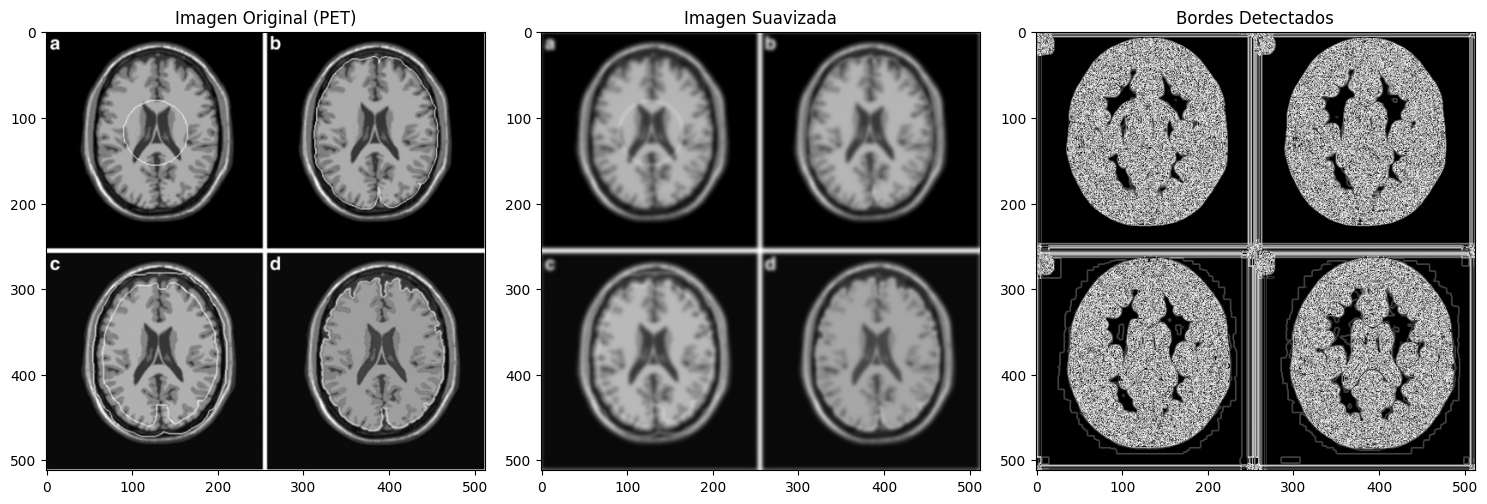

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter

# Función para cargar la imagen (usando una imagen de ejemplo PET)
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    return np.array(image)

# Filtro Gaussiano para suavizado
def gaussian_blur(image, sigma=2):
    return gaussian_filter(image, sigma=sigma)

# Operador Sobel en X y Y
def sobel(image):
    # Filtros Sobel
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Aplicar convolución (sin usar OpenCV)
    grad_x = convolution(image, kernel_x)
    grad_y = convolution(image, kernel_y)

    # Magnitud del gradiente
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return magnitude

# Función de ecualización de histograma para mejorar contraste
def histogram_equalization(image):
    # Normalizar y aplicar ecualización de histograma
    image_hist, bins = np.histogram(image.flatten(), bins=256, range=[0,256])
    cdf = image_hist.cumsum()
    cdf_normalized = cdf * float(image_hist.max()) / cdf.max()  # Normalizar la CDF
    image_eq = np.interp(image.flatten(), bins[:-1], cdf_normalized)
    return image_eq.reshape(image.shape)

# Convolución con un kernel específico
def convolution(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Padding para manejar los bordes
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded_image[i:i+kernel_h, j:j+kernel_w]
            result[i, j] = np.sum(region * kernel)

    return result

# Función para mostrar las imágenes
def display_images(original, smoothed, edges):
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Imagen Original (PET)")

    plt.subplot(1, 3, 2)
    plt.imshow(smoothed, cmap='gray')
    plt.title("Imagen Suavizada")

    plt.subplot(1, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.title("Bordes Detectados")

    plt.tight_layout()
    plt.show()

# Cargar la imagen PET (reemplaza la ruta de la imagen)
image_path = 'data/2.png'  # Asegúrate de tener una imagen PET adecuada
image = load_image(image_path)

# Paso 1: Suavizado (Filtro Gaussiano)
smoothed_image = gaussian_blur(image, sigma=2)

# Paso 2: Detección de bordes (Sobel)
edges_image = sobel(smoothed_image)

# Paso 3: Ajuste de contraste (Ecualización de histograma) - Se puede omitir si no se necesita mostrar la imagen mejorada
# enhanced_image = histogram_equalization(smoothed_image)

# Mostrar los resultados
display_images(image, smoothed_image, edges_image)